# Label Studio MP3 DataLoader (PyTorch)

This notebook loads your Label Studio JSON export and corresponding MP3 files into a PyTorch `Dataset` and `DataLoader`.

In [1]:
from pathlib import Path
from urllib.parse import urlparse, parse_qs
import json
from typing import Dict, List, Tuple

import torch
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torch.nn.functional as F

In [2]:
# Update these paths if needed
JSON_PATH = Path('../data/train/project-2-at-2026-02-17-19-13-29048d75.remapped.json')
AUDIO_DIR = Path('../data/train')
TARGET_SAMPLE_RATE = 16000

assert JSON_PATH.exists(), f'Missing JSON file: {JSON_PATH.resolve()}'
assert AUDIO_DIR.exists(), f'Missing audio dir: {AUDIO_DIR.resolve()}'

In [3]:
def _extract_filename(task: Dict) -> str:
    """Resolve filename from Label Studio task fields."""
    file_upload = task.get('file_upload')
    if isinstance(file_upload, str) and file_upload:
        return Path(file_upload).name

    audio_val = task.get('data', {}).get('audio', '')
    if isinstance(audio_val, str) and audio_val:
        parsed = urlparse(audio_val)
        if parsed.query:
            d_vals = parse_qs(parsed.query).get('d', [])
            if d_vals:
                return Path(d_vals[0]).name
        return Path(parsed.path).name

    raise ValueError(f'Could not resolve filename for task id={task.get("id")}')


def _collect_segments(task: Dict) -> List[Dict]:
    """Get segment annotations from the first annotation object."""
    annotations = task.get('annotations', [])
    if not annotations:
        return []

    results = annotations[0].get('result', [])
    segments = []
    for r in results:
        value = r.get('value', {})
        labels = value.get('labels', [])
        if not labels:
            continue
        segments.append({
            'start': float(value.get('start', 0.0)),
            'end': float(value.get('end', 0.0)),
            'label': str(labels[0]),
        })
    return segments

In [4]:
class LabelStudioAudioDataset(Dataset):
    def __init__(self, json_path: Path, audio_dir: Path, target_sr: int = 16000):
        self.json_path = Path(json_path)
        self.audio_dir = Path(audio_dir)
        self.target_sr = target_sr

        with self.json_path.open('r', encoding='utf-8') as f:
            tasks = json.load(f)

        self.items = []
        label_set = set()

        for task in tasks:
            filename = _extract_filename(task)
            audio_path = self.audio_dir / filename
            segments = _collect_segments(task)

            for seg in segments:
                label_set.add(seg['label'])

            self.items.append({
                'task_id': task.get('id'),
                'audio_path': audio_path,
                'segments': segments,
            })

        self.labels = sorted(label_set)
        self.label2id = {l: i for i, l in enumerate(self.labels)}

        missing = [str(x['audio_path']) for x in self.items if not x['audio_path'].exists()]
        if missing:
            preview = '\n'.join(missing[:10])
            raise FileNotFoundError(f'Missing {len(missing)} audio files, first entries:\n{preview}')

    def __len__(self):
        return len(self.items)

    def _load_audio(self, audio_path: Path) -> torch.Tensor:
        wav, sr = torchaudio.load(str(audio_path))  # [channels, samples]
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0, keepdim=True)  # mono

        if sr != self.target_sr:
            wav = torchaudio.functional.resample(wav, orig_freq=sr, new_freq=self.target_sr)

        return wav.squeeze(0)  # [samples]

    def __getitem__(self, idx: int):
        item = self.items[idx]
        waveform = self._load_audio(item['audio_path'])

        segs = []
        for seg in item['segments']:
            segs.append({
                'start_sec': seg['start'],
                'end_sec': seg['end'],
                'start_sample': int(seg['start'] * self.target_sr),
                'end_sample': int(seg['end'] * self.target_sr),
                'label': seg['label'],
                'label_id': self.label2id[seg['label']],
            })

        return {
            'task_id': item['task_id'],
            'audio_path': str(item['audio_path']),
            'waveform': waveform,
            'num_samples': int(waveform.shape[0]),
            'sample_rate': self.target_sr,
            'segments': segs,
        }

In [5]:
def collate_with_padding(batch: List[Dict]) -> Dict:
    lengths = torch.tensor([x['num_samples'] for x in batch], dtype=torch.long)
    max_len = int(lengths.max().item())

    padded = []
    for x in batch:
        w = x['waveform']
        if w.shape[0] < max_len:
            w = F.pad(w, (0, max_len - w.shape[0]))
        padded.append(w)

    waveforms = torch.stack(padded, dim=0)  # [B, T]

    return {
        'task_id': [x['task_id'] for x in batch],
        'audio_path': [x['audio_path'] for x in batch],
        'waveform': waveforms,
        'lengths': lengths,
        'sample_rate': batch[0]['sample_rate'],
        'segments': [x['segments'] for x in batch],
    }

In [6]:
dataset = LabelStudioAudioDataset(JSON_PATH, AUDIO_DIR, target_sr=TARGET_SAMPLE_RATE)
print('num items:', len(dataset))
print('labels:', dataset.labels)

loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_with_padding,
)

num items: 8
labels: ['barking', 'noise']


In [7]:
batch = next(iter(loader))
print('waveform shape [B, T]:', tuple(batch['waveform'].shape))
print('lengths:', batch['lengths'].tolist())
print('sample_rate:', batch['sample_rate'])
print('first audio path:', batch['audio_path'][0])
print('first sample segments (count):', len(batch['segments'][0]))
if batch['segments'][0]:
    print('first segment example:', batch['segments'][0][0])

waveform shape [B, T]: (2, 746155)
lengths: [436636, 746155]
sample_rate: 16000
first audio path: ../data/train/001.mp3
first sample segments (count): 0


Segments per label:
  barking: 41 segments
  noise: 43 segments
  non-labeled: 2 segments


/Users/ksetdekov/Code/bark_detector/env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


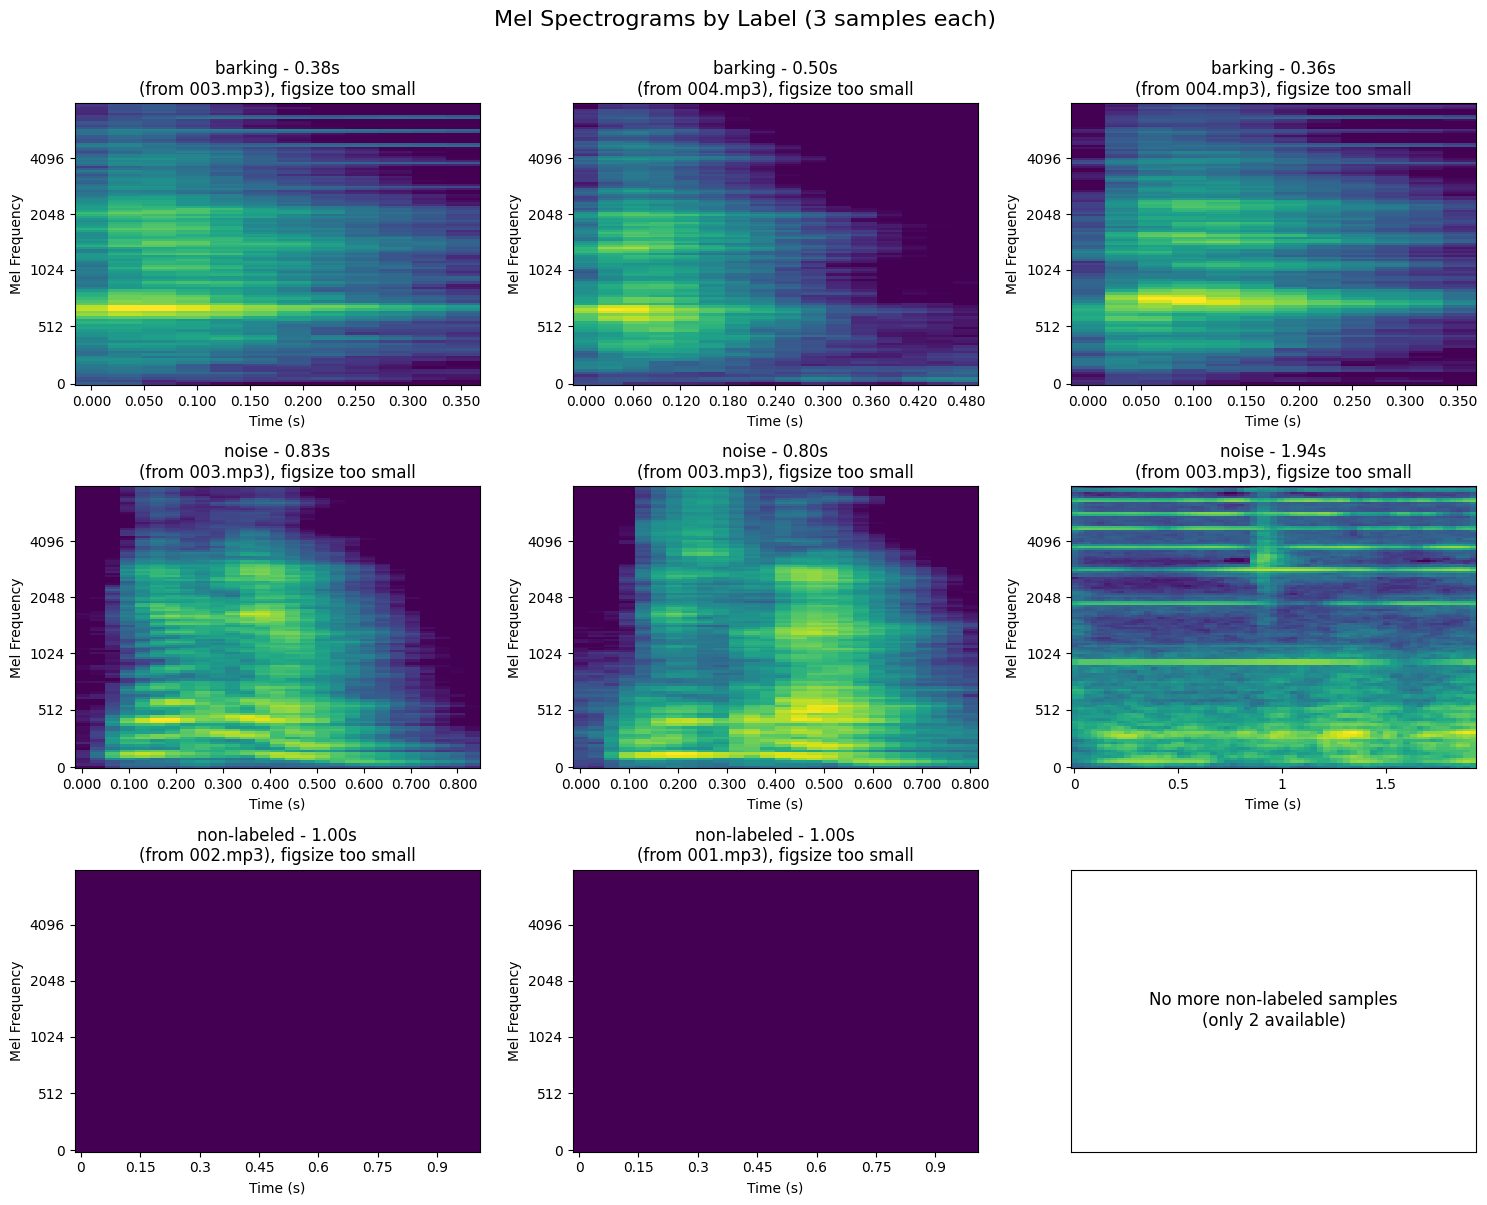


Spectrogram visualization complete!


In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import librosa
import librosa.display
import numpy as np

# Mel spectrogram parameters
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512

# Collect segments by label
segments_by_label = {label: [] for label in dataset.labels}
segments_by_label['non-labeled'] = []

for idx in range(len(dataset)):
    item = dataset[idx]
    waveform = item['waveform'].numpy()
    
    if not item['segments']:
        # Non-labeled audio - take a random chunk
        if len(waveform) > TARGET_SAMPLE_RATE:
            start = np.random.randint(0, len(waveform) - TARGET_SAMPLE_RATE)
            segments_by_label['non-labeled'].append({
                'audio': waveform[start:start + TARGET_SAMPLE_RATE],
                'label': 'non-labeled',
                'audio_path': item['audio_path']
            })
    else:
        for seg in item['segments']:
            start_sample = seg['start_sample']
            end_sample = seg['end_sample']
            label = seg['label']
            
            audio_seg = waveform[start_sample:end_sample]
            if len(audio_seg) > 0:
                segments_by_label[label].append({
                    'audio': audio_seg,
                    'label': label,
                    'audio_path': item['audio_path']
                })

# Print statistics
print("Segments per label:")
for label, segs in segments_by_label.items():
    print(f"  {label}: {len(segs)} segments")

# Create visualization for each label
fig, axes = plt.subplots(len(dataset.labels) + 1, 3, figsize=(15, 4 * (len(dataset.labels) + 1)))
fig.suptitle('Mel Spectrograms by Label (3 samples each)', fontsize=16, y=1.00)

# Process each label
all_labels = list(dataset.labels) + ['non-labeled']
for row, label in enumerate(all_labels):
    segs = segments_by_label[label]
    num_samples = min(3, len(segs))
    
    for col in range(3):
        ax = axes[row, col]
        
        if col < num_samples:
            seg = segs[col]
            audio = seg['audio']
            
            # Compute mel spectrogram
            S = librosa.feature.melspectrogram(
                y=audio,
                sr=TARGET_SAMPLE_RATE,
                n_mels=N_MELS,
                n_fft=N_FFT,
                hop_length=HOP_LENGTH
            )
            S_db = librosa.power_to_db(S, ref=np.max)
            
            # Display
            img = librosa.display.specshow(
                S_db,
                sr=TARGET_SAMPLE_RATE,
                hop_length=HOP_LENGTH,
                x_axis='time',
                y_axis='mel',
                ax=ax,
                cmap='viridis'
            )
            ax.set_title(f'{label} - {len(audio)/TARGET_SAMPLE_RATE:.2f}s\n(from {Path(seg["audio_path"]).name}), figsize too small')
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Mel Frequency')
        else:
            ax.text(0.5, 0.5, f'No more {label} samples\n(only {len(segs)} available)',
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])

plt.tight_layout()
plt.show()

print("\nSpectrogram visualization complete!")